## Polygenic Scores for Insecticide Resistance Surveillance

- [Introductory slides](https://docs.google.com/presentation/d/1qpefQbitedxnI68M82BNK2bZGOC6cPDSXSumE1DpMPY/edit?usp=sharing)
- [Git Repo](https://github.com/LSTM-VIGG/pgs)

In this workshop, we will explore how **polygenic scores (PGS)** can be used to quantify and track **insecticide resistance** in malaria vector populations.    

We will work with MalariaGEN-derived genomic data (`malariagen_data`) and use effect size estimates from a recent targeted amplicon sequencing study using the Ag-vampIR + AmpSeeker platform ([Nagi et al., 2025, *bioRxiv*](https://www.biorxiv.org/content/10.1101/2025.02.14.637727v2)).

This notebook will guide you through:
- Understanding and interpreting polygenic scores in a vector genomics context  
- Using effect size data (odds ratios) to compute polygenic scores  
- Applying PGS to individual and population (cohort) mosquito genotype datasets  

#### Why Use Polygenic Scores for Resistance Surveillance?

Resistance to insecticides is typically polygenic in nature; many loci contribute to the resistant phenotype. However, traditional resistance diagnostics focus on *single* mutations (e.g. Vgsc-995F) which capture only a small fraction of phenotypic variation, and therefore their actual utility for disease control programmes is limited. Advances in whole-genome and targeted sequencing are now making it possible to affordably genotype mosquitoes at many loci across the genome, but to take advantage of this, we need methods that can summarise the phenotypic effect of those genotypes.

#### What Are Polygenic Scores?

A **polygenic score (PGS)** — sometimes called a genetic risk score (GRS) — is a single numerical value summarizing the *cumulative contribution* of multiple genetic variants to a particular phenotype.  

For insecticide resistance, this phenotype reflects the ability of a mosquito to survive exposure to an insecticide. Each single-nucleotide polymorphism (SNP) or mutation has an **effect size (β, log odds ratio)** that indicates its strength and direction of association with resistance to a given insecticide. To calculate the polygenic score, we simply multiply the effect size by the genotype dosage (0,1,2) and sum across variants.

For an individual mosquito $i$, the polygenic score can be represented mathematically as:

$PGS_i = \sum_{j=1}^{m} \beta_j \times G_{ij}$

where:  
- $m$ = number of variants included  
- $beta_j$ = estimated *effect size* (e.g. log odds ratio) of variant $j$
- $G_{ij}$ = genotype dosage (0, 1, or 2 copies of the resistance allele) for individual $i$

This creates a quantitative summary measure that captures small, additive contributions from many loci across the genome — providing a framework for polygenic forms of resistance that cannot be explained by single-point mutations alone.

Polygenic scores provide several key advantages:

- **Interpretable:** Single easy to interpret value to communicate to policy-makers.
- **Standardised:** Enable simple comparisons across studies, populations, and time points.
- **Quantitative:** Translate genetic information into a measurable, continuous trait.

<figure style="text-align: center;">
  <img src="pgs-fig1.png" alt="Figure placeholder for PGS schematic" width="600">
  <figcaption><em>Conceptual overview of polygenic score construction for insecticide resistance.</em></figcaption>
</figure>

---

### Workshop Overview

In this introductory notebook, we will cover:

1. **Data Import** — Loading `malariagen_data` genotypes for target SNPs.  
2. **Effect Sizes** — Importing and inspecting effect sizes (β values / log odds ratios) from the Ag-vampIR + AmpSeeker study.  
3. **PGS Calculation** — Computing per-individual scores from allele dosages and effect sizes.  
4. **Population-Level Summaries** — Aggregating scores to obtain population or cohort-level *mean PGS* values.  
5. **Visualization & Interpretation** — Plotting PGS distributions, assessing variation across geography or time.

In [ ]:
import malariagen_data
import numpy as np
import pandas as pd
import allel
from tqdm.notebook import tqdm
# !wget -q https://raw.githubusercontent.com/<user>/<repo>/main/pgs_helpers.py
import pgs_helpers as pgs

ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release_master_us_central1/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.10, 3.11, 3.12, 3.13, 3.14
Results cache           : None
Cohorts analysis        : 20250815
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 15.4.0.post17+36f6d515
Client location         : Nairobi County, Kenya
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.4.0.post17+36f6d515/Ag3.html

#### Load effect size data

Lets load the effect size data. The key columns we will need are the `odds_ratio` column and `snp_id`, which tells us the contig, position and alternate allele of the resistance mutation. We can also see other information, such as the p-value and whether this SNP passed FDR control.

In [97]:
df_effects = pd.read_csv("./llineup-epi-ir/./glm-siaya-effect-size-targets.csv", index_col=0)
df_effects = df_effects.set_index('snp_id')
df_effects.head()

,odds_ratio,pvals,conf_lower,conf_higher,sig,fdr,fdr_sig,POS_ALT,ANN
snp_id,,,,,,,,,
snp_2R:17854287_A,0.907066,5.998756e-01,0.630037,1.305905,False,0.887816,False,17854287_C>A,A|synonymous_variant|LOW|GPR5HT2A|AGAP002232|t...
snp_2R:28497967_C,3.244042,1.503645e-07,2.091034,5.032824,True,0.000003,True,28497967_G>C,C|missense_variant|MODERATE|CYP6P4|AGAP002867|...
snp_2R:28502850_T,3.401437,1.426293e-07,2.155882,5.366608,True,0.000003,True,28502850_C>T,T|synonymous_variant|LOW|CYP6P2|AGAP002869|tra...
snp_2R:49438586_C,0.497835,1.828692e-01,0.178384,1.389365,False,0.375898,False,49438586_T>C,C|3_prime_UTR_variant|MODIFIER|AGAP013121|AGAP...
snp_3R:34264_G,1.206841,3.696125e-01,0.800355,1.819774,False,0.621621,False,34264_A>G,G|intron_variant|MODIFIER|AGAP007732|AGAP00773...


In [93]:
df_effects.shape

(37, 10)

#### Remove SNPs in high LD

In [ ]:
## blah blah 

#### Load genotype data for these SNPs with malariagen_data

In [ ]:
# define sample sets and query
sample_set = 'AG1000G-UG'
sample_query = "taxon == 'gambiae'"

# load sample metadata 
df_samples = ag3.sample_metadata(sample_set, sample_query)
df_samples.shape

(207, 57)

Lets retrieve snp_calls for every SNP in our effect size data. We will use the `snp_id` column to get the contig, position and alternate allele for each SNP, then call malariagen_data.snp_calls. Because we have relatively few SNPs to retrieve (37), I will loop through each SNP and retrieve them one at a time.

In [ ]:
# setup lists to hold genotype arrays, alt alleles and positions
gns = []
alts = []
poss = []

# loop through each SNP in the effect size data
for i, row in tqdm(df_effects.iterrows()):

    # get the region string from the snp_id
    loc = row.snp.replace("snp_", "").split("_")[0]
    region = f"{loc}-{loc.split(":")[1]}"
    
    # get the snp calls for this region
    ds_snps = ag3.snp_calls(region=region, sample_sets=sample_set, sample_query=sample_query)
    gn = allel.GenotypeArray(ds_snps['call_genotype'].values)
    alt = ds_snps['variant_allele'].values
    pos = ds_snps['variant_position'].values
    
    gns.append(allel.GenotypeDaskArray(ds_snps["call_genotype"].data))
    alts.append(alt)
    poss.append(pos)

# concatenate the genotype arrays, alt alleles and positions
gn = gns[0].concatenate(gns[1:], axis=0).compute()
alts = np.concatenate(alts).astype(str)
pos = np.concatenate(poss)
samples = ds_snps['sample_id'].values

0it [00:00, ?it/s]

#### Calculate the number of resistance alleles (genotype dosage) for each variant/individual

As we are working with relatively few SNPs, I'm going to use pandas dataframes to hold the genotype data. For larger numbers of SNPs (for example, from a GWAS), you would want to use a more efficient data structure, such as scikit-allel's `allel.GenotypeArray`.

In [ ]:
# create a dataframe with contig, pos, ref, alt information
contigs = df_effects.snp.str.split(":").str.get(0).str.replace("snp_", "").values
df_var = pd.DataFrame({'contig': contigs, 'pos': pos, 'ref': alts[:, 0].astype(str), 'alt': np.apply_along_axis(lambda x: ','.join(x), axis=1, arr=alts[:, 1:].astype(str))})

# create a dataframe with genotypes
df_geno = pd.DataFrame(gn.to_gt().astype(str), columns=samples)

# combine var_df and df_geno
df_geno = pd.concat([df_var, df_geno], axis=1)
df_geno.head(3)

,contig,pos,ref,alt,AC0089-Cx,AC0090-C,AC0091-Cx,AC0092-C,AC0093-C,AC0094-C,...,AC0290-C,AC0291-C,AC0292-C,AC0293-C,AC0294-C,AC0295-C,AC0296-C,AC0297-C,AC0298-C,AC0299-C
0,2R,17854287,C,"A,T,G",1/1,1/1,1/1,1/1,1/1,1/1,...,1/1,1/1,1/1,1/1,1/1,1/1,1/1,1/1,1/1,1/1
1,2R,28497967,G,"A,C,T",0/2,2/2,2/2,2/2,0/2,0/2,...,0/2,0/2,2/2,2/2,0/2,2/2,0/2,2/2,2/2,0/2
2,2R,28502850,C,"A,T,G",0/2,2/2,2/2,2/2,0/2,0/2,...,2/2,2/2,2/2,0/2,2/2,2/2,0/2,2/2,2/2,2/2


As we have some alleles which are multiallelic, we will need to split these into multiple rows, one for each alternate allele. We will then convert the genotype strings (e.g. "0/1") into a count of the number of alternate alleles (0, 1 or 2).

In [ ]:
df_geno = pgs.split_rows_with_multiple_alleles(df_geno, samples)
df_geno = pgs.convert_genotype_to_alt_allele_count(df_geno, samples)

# create a snp_id column and set as index, and drop unneeded columns
df_geno = df_geno.assign(snp_id=lambda x: "snp_" + x.contig + ":" + x.pos.astype(str) + "_" + x.alt)
df_geno = df_geno.set_index('snp_id')
df_geno = df_geno.drop(columns=['contig', 'pos', 'ref', 'alt'])
df_geno.head(3)

,AC0089-Cx,AC0090-C,AC0091-Cx,AC0092-C,AC0093-C,AC0094-C,AC0095-C,AC0096-Cx,AC0097-C,AC0098-C,...,AC0290-C,AC0291-C,AC0292-C,AC0293-C,AC0294-C,AC0295-C,AC0296-C,AC0297-C,AC0298-C,AC0299-C
snp_id,,,,,,,,,,,,,,,,,,,,,
snp_2R:17854287_A,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
snp_2R:17854287_T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snp_2R:17854287_G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snp_2R:28497967_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snp_2R:28497967_C,1,2,2,2,1,1,2,1,1,2,...,1,1,2,2,1,2,1,2,2,1
snp_2R:28497967_T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snp_2R:28502850_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snp_2R:28502850_T,1,2,2,2,1,1,2,1,1,2,...,2,2,2,1,2,2,1,2,2,2
snp_2R:28502850_G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can select only the snp_ids which are in our effect size data, and calculate PGS.

In [ ]:
target_snps = df_effects.index.to_list()

df_pgs = pgs.calculate_pgs(df_geno.loc[target_snps], df_effects, df_samples)
df_pgs.head()

Lets look at the distribution of PGS values across individuals.

<Axes: >

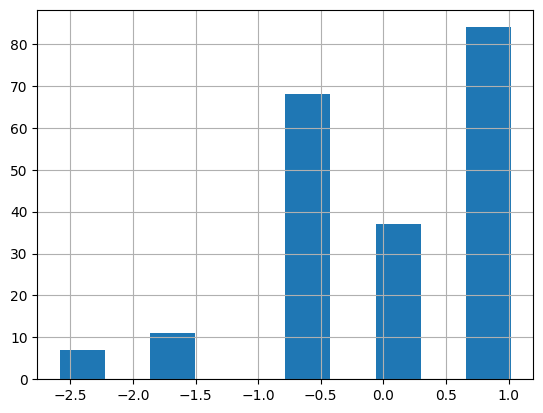

In [117]:
df_pgs.pgs.hist()